In [1]:
# Setup
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import normalize
from tqdm.auto import trange, tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
# device = "cpu"
print(f"DEVICE: {device}")

DEVICE: cuda


In [2]:
class Norms(Dataset):

    def __init__(self, states_norms, forces_norms):
        super().__init__()
        self.states_norms = states_norms
        self.forces_norms = forces_norms
        if len(states_norms) == len(forces_norms):
            self.length = len(states_norms)
        else:
            raise ValueError("States and forces must be the same length.")
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        state_norms = torch.tensor(self.states_norms[index], dtype=torch.float32)
        force_norms = torch.tensor(self.forces_norms[index], dtype=torch.float32)

        return state_norms, force_norms 
    
class ModelAN(nn.Module):

    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(12, 25),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 4)
        )

    def forward(self, x):
        return self.layers(x)
    
def preprocessing_from_matlab(data):
    key = list(data.keys())[-1]
    all_data = data[key].squeeze()
    all_data_normalized = []
    all_data_norms = []

    for data in all_data:
        data_normalized, data_norms = normalize(X=data.T,
                                                axis=0,
                                                return_norm=True)
        data_norms
        all_data_normalized.append(data_normalized)
        all_data_norms.append(data_norms)

    return all_data_normalized, all_data_norms

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss

def test(dataloader, model, loss_fn):
    model.eval()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        test_pred = model(X)
        test_loss = loss_fn(test_pred, y)

    return test_loss

In [3]:
# Loading the MATLAB files.
forces = loadmat("../tau_all.mat")
states = loadmat("../xs_all.mat")

In [4]:
all_forces, forces_norms = preprocessing_from_matlab(forces)
all_states, states_norms = preprocessing_from_matlab(states)

In [5]:
dataset = Norms(states_norms, forces_norms)

In [6]:
train_data_norms, test_data_norms = torch.utils.data.random_split(dataset, [0.8, 0.2])

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data_norms,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data_norms,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

print(f"Lenght of train data (norms): {len(train_dataloader)}")
print(f"Lenght of test data (norms): {len(test_dataloader)}")

Lenght of train data (norms): 800
Lenght of test data (norms): 200


In [7]:
print("Input:")
print((train_data_norms[500][0]))
print("Output:")
print((train_data_norms[500][1]))

Input:
tensor([ 31.0256,  32.1728,  35.2074,   8.5817,   7.2866,  25.3695, 118.5288,
        118.1968, 410.9297,   2.9378,   3.1315,   5.9688])
Output:
tensor([3.0548e+03, 5.4232e-01, 1.1935e+00, 2.7186e+00])


In [8]:
model = ModelAN().to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 1001
loss_overall = []
loss_overall_test = []

for epoch in trange(epochs): 
    loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
        print("~"*50)
    loss_overall.append(loss.item())
    loss_overall_test.append(test_loss.item())
    
print("Done!")

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 766.19812, Test loss: 765.08057
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 200 | Train loss: 133.97827, Test loss: 60.46869
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 400 | Train loss: 102.74946, Test loss: 71.02737
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 600 | Train loss: 2.41966, Test loss: 4.53929
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 800 | Train loss: 6.89752, Test loss: 3.76812
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1000 | Train loss: 3.37830, Test loss: 4.45447
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done!


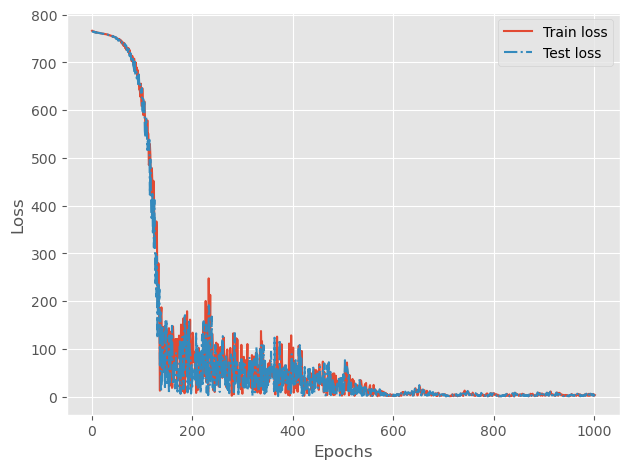

In [10]:
t = np.linspace(1, epochs, epochs)
plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.plot(t, loss_overall, label='Train loss')
ax.plot(t, loss_overall_test, label='Test loss', ls="-.")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()

In [11]:
torch.save(model.state_dict(), "model_norms.pt")